In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import arviz as az

import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, WeibullFitter
from lifelines.utils import median_survival_times

In [2]:
ALPHA=0.11

In [3]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Time to discontinuation of the use of an IUD.dat", sep="\s+")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_16557/1545641242.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Time to discontinuation of the use of an IUD.dat", sep="\s+")


In [4]:
DatOriginal.head()

,time,status
0,10,1
1,13,0
2,18,0
3,19,1
4,23,0


In [5]:
KM = KaplanMeierFitter()
KM.fit(DatOriginal['time'], DatOriginal['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 18 total observations, 9 right-censored observations>

Suitability of Weibull distribution

/tmp/ipykernel_16557/32517146.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


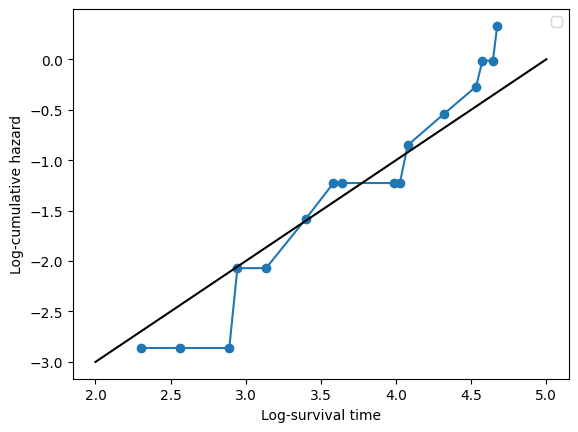

In [6]:
_ = (-np.log(KM.survival_function_['KM_estimate'])).reset_index().drop_duplicates()

plt.plot(np.log(_['timeline']), np.log(_['KM_estimate']))
plt.scatter(np.log(_['timeline']), np.log(_['KM_estimate']))
plt.plot([2,5], [-3,0], color='k')

plt.xlabel("Log-survival time")
plt.ylabel("Log-cumulative hazard")
plt.legend()

Suitability of log-logistic distribution

In [7]:
_ = (np.log(KM.survival_function_['KM_estimate']/(1-KM.survival_function_['KM_estimate']))).reset_index().drop_duplicates()

/tmp/ipykernel_16557/2620426752.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


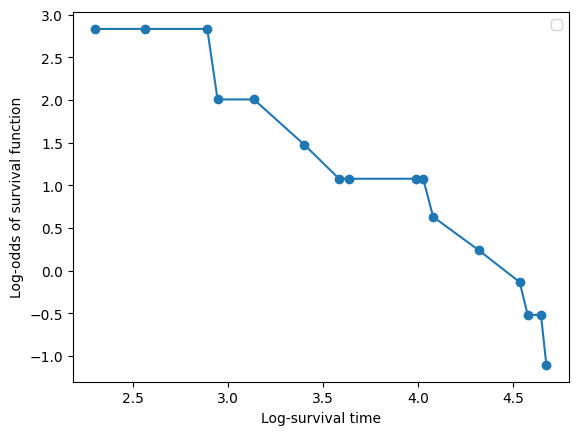

In [8]:
_ = (np.log(KM.survival_function_['KM_estimate']/(1-KM.survival_function_['KM_estimate']))).reset_index().drop_duplicates()

plt.plot(np.log(_['timeline']), _['KM_estimate'])
plt.scatter(np.log(_['timeline']), _['KM_estimate'])

plt.xlabel("Log-survival time")
plt.ylabel("Log-odds of survival function")
plt.legend()

---

Fitting a Weibull model

$\lambda$ is what is tipically denoted as $\beta$, i.e. the scale parameter.

$\rho$ is what is tipically denoted as $\alpha$, i.e. the shape parameter.

In [9]:
WeibModel = WeibullFitter()
WeibModel.fit(DatOriginal['time'], DatOriginal['status'])

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 18 total observations, 9 right-censored observations>

In [10]:
WeibModel.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 18 total observations, 9 right-censored observations>
   number of observations = 18
number of events observed = 9
           log-likelihood = -50.35
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 98.64     20.16           59.13          138.16
rho_     1.68      0.46            0.77            2.58

         cmp to    z      p  -log2(p)
lambda_    1.00 4.84 <0.005     19.58
rho_       1.00 1.47   0.14      2.82
---
AIC = 104.70

<Axes: xlabel='timeline'>

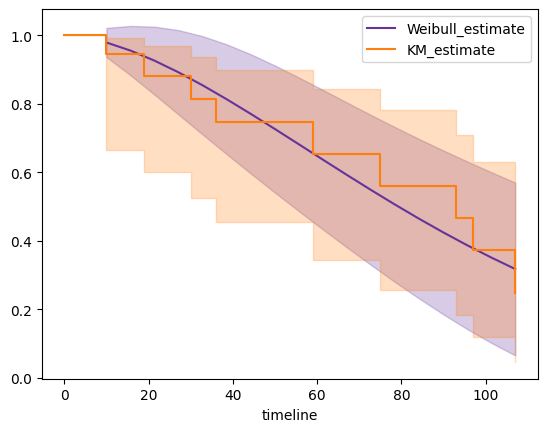

In [11]:
WeibModel.plot_survival_function(color='rebeccapurple')
KM.plot_survival_function()

In [12]:
WeibModel.median_survival_time_

79.27222032047071

In [13]:
median_survival_times(WeibModel.confidence_interval_)

,Weibull_estimate_lower_0.95,Weibull_estimate_upper_0.95
0.5,10.0,inf


---

Fit the Weibull model using Bayesian statistics

In [14]:
ObservedTimes = DatOriginal.loc[DatOriginal["status"]==1, "time"].values
CensoredTimes = DatOriginal.loc[DatOriginal["status"]==0, "time"].values

In [15]:
# Weibull log-survivor function
def WeibullLogSurvivor(t, alpha, beta):
    return -1/beta**alpha * t**alpha

# Weibull survivor function
def WeibullSurvivor(t, alpha, beta):
    return np.exp(WeibullLogSurvivor(t, alpha, beta))

# Time quantile
def TimeQuantile(p, alpha, beta):
    return beta * (-np.log(1-p))**(1/alpha)

In [16]:
with pm.Model() as WeibullBayesian:
    Alpha = pm.HalfFlat("Alpha") # Non-informative prior
    Lambda = pm.Gamma("Lambda", alpha=1, beta=0.001) # Vague prior
    #lam = pm.HalfFlat("lambda") # Non-informative prior
    Beta = pm.Deterministic("Beta", 1/Lambda**(1/Alpha))

    # Time quantile
    MedianTime = pm.Deterministic("MedianTime", TimeQuantile(0.5, Alpha, Beta))

    TimeObs = pm.Weibull("TimesObserved", Alpha, Beta, observed=ObservedTimes)
    TimeCens = pm.Potential("TimesCensored", WeibullLogSurvivor(CensoredTimes, Alpha, Beta))

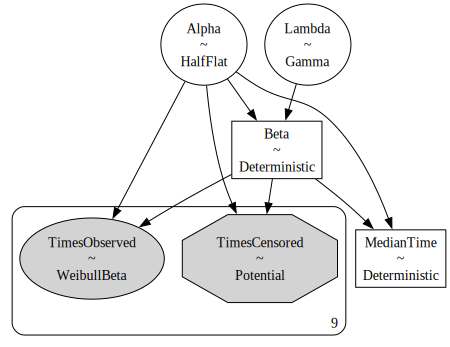

In [17]:
pm.model_to_graphviz(WeibullBayesian)

In [18]:
with WeibullBayesian:
    TraceWeibull = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Lambda]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [19]:
az.summary(TraceWeibull, hdi_prob=1-ALPHA)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Alpha,1.143,0.321,0.633,1.640,0.013,0.009,621.0,774.0,1.01
Beta,116.723,51.868,57.544,168.324,1.287,0.910,2811.0,1781.0,1.00
Lambda,0.011,0.016,0.000,0.027,0.001,0.000,641.0,765.0,1.01
MedianTime,81.342,30.493,40.822,115.066,0.629,0.475,3127.0,1842.0,1.00


In [20]:
az.summary(TraceWeibull, kind="stats", stat_focus="median", hdi_prob=1-ALPHA)

,median,mad,eti_5.5%,eti_94.5%
Alpha,1.123,0.216,0.662,1.684
Beta,103.964,19.733,68.961,200.711
Lambda,0.005,0.004,0.000,0.039
MedianTime,75.316,14.029,48.248,129.837


(0.0, 200.0)

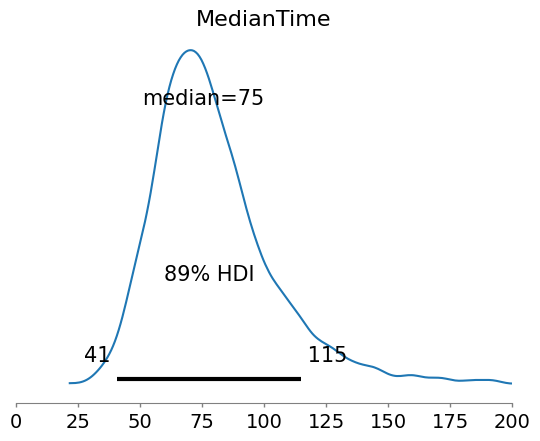

In [21]:
az.plot_posterior(TraceWeibull, var_names="MedianTime", point_estimate="median", hdi_prob=1-ALPHA)
plt.xlim(0,200)

In [22]:
t_vect = np.linspace(0, 140)

In [23]:
for t in t_vect:
    if t==t_vect[0]:
        Survivor = az.summary(
            WeibullSurvivor(
                t,
                TraceWeibull.posterior["Alpha"],
                TraceWeibull.posterior["Beta"]
            ),
            hdi_prob=1-ALPHA
        )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
    else:
        Survivor = pd.concat([
            Survivor,
            az.summary(
                WeibullSurvivor(
                    t,
                    TraceWeibull.posterior["Alpha"],
                    TraceWeibull.posterior["Beta"]
                ),
                hdi_prob=1-ALPHA
            )[["mean", "hdi_"+str((ALPHA/2)*100)+"%", "hdi_"+str((1-ALPHA/2)*100)+"%"]]
        ])
        
Survivor['time'] = t_vect

<Axes: xlabel='timeline'>

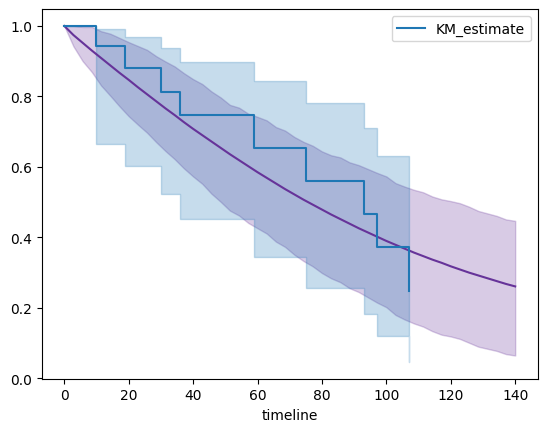

In [24]:
plt.plot(Survivor["time"], Survivor["mean"], color='rebeccapurple')
plt.fill_between(
    Survivor["time"],
    Survivor["hdi_"+str((ALPHA/2)*100)+"%"],
    Survivor["hdi_"+str((1-ALPHA/2)*100)+"%"],
    alpha=0.25,
    color="rebeccapurple"
)

KM.plot_survival_function()